<a href="https://colab.research.google.com/github/ramaastra/sekarya-machine-learning/blob/main/sekarya_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Bangkit_Dataset/Dataset_Sekarya1
#!ls drive/MyDrive/Dataset_Sekarya1

test  test.csv	train  train.csv


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [ ]:
train_dir = '/content/drive/MyDrive/Bangkit_Dataset/Dataset_Sekarya1/train'
val_dir = '/content/drive/MyDrive/Bangkit_Dataset/Dataset_Sekarya1/test'
#train_dir = '/content/drive/MyDrive/Dataset_Sekarya1/train'
#val_dir = '/content/drive/MyDrive/Dataset_Sekarya1/test'

train_fake_dir = os.path.join(train_dir, 'fake')
train_real_dir = os.path.join(train_dir, 'real')

val_fake_dir = os.path.join(val_dir, 'fake')
val_real_dir = os.path.join(val_dir, 'real')

print(f"There are {len(os.listdir(train_fake_dir))} images of fake images for training.\n")
print(f"There are {len(os.listdir(train_real_dir))} images of real images for training.\n")
print(f"There are {len(os.listdir(val_fake_dir))} images of fake images for validation.\n")
print(f"There are {len(os.listdir(val_real_dir))} images of real images for validation.\n")

There are 2057 images of fake images for training.

There are 3027 images of real images for training.

There are 518 images of fake images for validation.

There are 754 images of real images for validation.



In [ ]:
def show_sample_images(sample_dir):
  random_image = random.sample(os.listdir(sample_dir), 1)
  img = mpimg.imread(sample_dir + '/' + random_image[0])
  plt.imshow(img)
  plt.title(f"Sample of {sample_dir.split('/')[-1]} Image")
  plt.axis('off')
  plt.show()

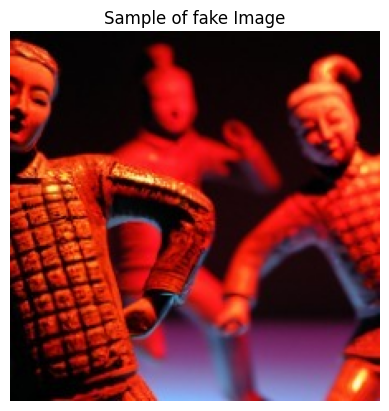

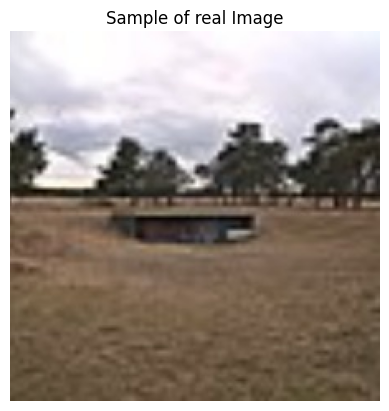

In [ ]:
show_sample_images(train_fake_dir)
print()
show_sample_images(train_real_dir)

In [ ]:
def train_val_generators(TRAIN_DIR, VAL_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))

  val_datagen = ImageDataGenerator(rescale=1./255)

  val_generator = val_datagen.flow_from_directory(directory=VAL_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))

  return train_generator, val_generator

In [ ]:
train_generator, val_generator = train_val_generators(train_dir, val_dir)

Found 5083 images belonging to 2 classes.
Found 1272 images belonging to 2 classes.


In [ ]:
def create_pre_trained_model():
  pre_trained_model = VGG19(input_shape=(224, 224, 3),
                            include_top=False,
                            weights=None)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
                self.model.stop_training = True

custom_callback = MyCallback()

In [ ]:
vgg = create_pre_trained_model()
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def create_model(with_vgg=True):
  model = tf.keras.Sequential()

  if with_vgg:
    model.add(vgg)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2)),
  else:
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
vgg_model = create_model(with_vgg=True)
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
vgg_model_history = vgg_model.fit(train_generator,
                                  epochs=100,
                                  verbose=1,
                                  callbacks=[custom_callback],
                                  validation_data=val_generator)

vgg_model.save("models/vgg-model.h5")

Epoch 1/100
159/159 [==============================] - 3721s 23s/step - loss: 0.6885 - accuracy: 0.5951 - val_loss: 0.6851 - val_accuracy: 0.5928
Epoch 2/100
159/159 [==============================] - 68s 426ms/step - loss: 0.6820 - accuracy: 0.5953 - val_loss: 0.6808 - val_accuracy: 0.5928
Epoch 3/100
159/159 [==============================] - 70s 444ms/step - loss: 0.6784 - accuracy: 0.5953 - val_loss: 0.6787 - val_accuracy: 0.5928
Epoch 4/100
159/159 [==============================] - 69s 435ms/step - loss: 0.6766 - accuracy: 0.5953 - val_loss: 0.6776 - val_accuracy: 0.5928
Epoch 5/100
159/159 [==============================] - 69s 434ms/step - loss: 0.6756 - accuracy: 0.5953 - val_loss: 0.6771 - val_accuracy: 0.5928
Epoch 6/100
159/159 [==============================] - 69s 437ms/step - loss: 0.6750 - accuracy: 0.5953 - val_loss: 0.6768 - val_accuracy: 0.5928
Epoch 7/100
159/159 [==============================] - 70s 443ms/step - loss: 0.6746 - accuracy: 0.5953 - val_loss: 0.6766 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
conv_model = create_model(with_vgg=False)
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
conv_model_history = conv_model.fit(train_generator,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=val_generator)

conv_model.save("models/conv-model.h5")

Epoch 1/100
159/159 [==============================] - 1287s 8s/step - loss: 0.6465 - accuracy: 0.6183 - val_loss: 0.6123 - val_accuracy: 0.6627
Epoch 2/100
159/159 [==============================] - 86s 545ms/step - loss: 0.5652 - accuracy: 0.7035 - val_loss: 0.6701 - val_accuracy: 0.6242
Epoch 3/100
159/159 [==============================] - 90s 566ms/step - loss: 0.4987 - accuracy: 0.7661 - val_loss: 0.5321 - val_accuracy: 0.7343
Epoch 4/100
159/159 [==============================] - 85s 530ms/step - loss: 0.4451 - accuracy: 0.8025 - val_loss: 0.5136 - val_accuracy: 0.7414
Epoch 5/100
159/159 [==============================] - 86s 538ms/step - loss: 0.3922 - accuracy: 0.8349 - val_loss: 0.4854 - val_accuracy: 0.7594
Epoch 6/100
159/159 [==============================] - 87s 545ms/step - loss: 0.3295 - accuracy: 0.8774 - val_loss: 0.4985 - val_accuracy: 0.7579
Epoch 7/100
159/159 [==============================] - 92s 575ms/step - loss: 0.2902 - accuracy: 0.8914 - val_loss: 0.4778 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_train_result(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.title(f'Model {metric.capitalize()}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
plot_train_result(vgg_model_history, 'accuracy')
print()
plot_train_result(vgg_model_history, 'loss')

In [ ]:
plot_train_result(conv_model_history, 'accuracy')
print()
plot_train_result(conv_model_history, 'loss')

In [ ]:
def test_sample_images(model, sample_dir, sample_size):
  correct_predictions_count = 0

  fig = plt.figure(figsize=(10, 3))
  row = 1

  random_images = random.sample(os.listdir(sample_dir), sample_size)

  for i, image in enumerate(random_images):
    fig.add_subplot(row, sample_size, i+1)

    image_path = f"{sample_dir}/{image}"
    img = mpimg.imread(image_path)

    x = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    y = model.predict(x)
    pred = "fake" if y[0][0] == 0 else "real"
    label = sample_dir.split('/')[-1]
    if pred == label:
      correct_predictions_count += 1

    title = plt.title(f"Prediction: {pred}")
    plt.setp(title, color=('g' if pred == label else 'r'))
    plt.imshow(img)
    plt.axis('off')

  fig.suptitle(f"{sample_dir.split('/')[-1].capitalize()} Images", fontsize=16)

  print(f"\n{correct_predictions_count}/{sample_size} was correctly predicted")

In [ ]:
test_sample_images(vgg_model, val_real_dir, sample_size=5)

In [ ]:
test_sample_images(vgg_model, val_fake_dir, sample_size=5)

In [ ]:
test_sample_images(conv_model, val_real_dir, sample_size=5)

In [ ]:
test_sample_images(conv_model, val_fake_dir, sample_size=5)